In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import legendre, hermitenorm
from scipy.integrate import nquad, quad, dblquad
from itertools import product
from numba import njit

In [2]:
@njit
def function(Z1, Z2):
    """
    Calculate the value of the given function.

    Args:
        Z1 (float): First input parameter.
        Z2 (float): Second input parameter.

    Returns:
        float: The value of the mathematical function.
    """
    # adapted such that no coordinate transformation is necessary
    return -(Z1) * (Z2)**3 + np.exp(-0.5*(Z1)**2 - 0.1 * (Z2)**2)

def get_pairs(max_order, dims=2):
    """
    Generate pairs of integers where sum of each pair is less than or equal to max_order.

    Args:
        max_order (int): The maximum integer value for pairs.
        dims (int, optional): Number of dimensions for the pairs. Default is 2.

    Returns:
        list: List of pairs of integers.
    """
    pairs = []
    for pair in product(np.arange(0, max_order), repeat=dims):
        if sum(pair) <= max_order:
            pairs.append(pair)
    return pairs

@njit
def normal_pdf(x, mu=0, sigma=1):
    """
    Calculate the probability density function (PDF) of a normal (Gaussian) distribution.

    Args:
        x (float or ndarray): The value(s) at which to evaluate the PDF.
        mu (float, optional): The mean (average) of the normal distribution. Default is 0.
        sigma (float, optional): The standard deviation of the normal distribution. Default is 1.

    Returns:
        float or ndarray: The PDF value(s) at the specified input value(s).
    """
    return 1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

def integral_nominator(Z1, Z2, phi1, phi2):
    """
    Calculate the integrand for a specific pair of Legendre and Hermite polynomials.

    Args:
        Z1 (float): First input parameter.
        Z2 (float): Second input parameter.
        phi1 : Legendre polynomial
        phi2 : Hermite polynomials.

    Returns:
        float: The value of the integrand.
    """
    f = function(Z1, Z2) # calculate f with transformed variables
    return f * phi1(Z1) * phi2(Z2) * 0.5 * normal_pdf(Z2)

def inner_leg(z, order):
    """
    Calculate the inner product of a Legendre polynomial of a given order.

    Args:
        z (float): The input value at which to evaluate the Legendre polynomial.
        order (int): The order of the Legendre polynomial.

    Returns:
        float: The inner product value.
    """
    phi = legendre(order)
    return phi(z) * phi(z) * 0.5

def inner_her(z, order):
    """
    Calculate the inner product of a Hermite polynomial of a given order.

    Args:
        z (float): The input value at which to evaluate the Hermite polynomial.
        order (int): The order of the Hermite polynomial.

    Returns:
        float: The inner product value.
    """
    phi = hermitenorm(order) 
    return phi(z) * phi(z) * normal_pdf(z)

def get_coefficents(max_order, dims=2):
    """
    Calculate coefficients for the pairs of Legendre and Hermite polynomials.

    Args:
        max_order (int): The maximum order for Legendre and Hermite polynomials.
        dims (int, optional): Number of dimensions. Default is 2.

    Returns:
        tuple: A tuple containing pairs of Legendre and Hermite polynomials, and their coefficients.
    """
    pairs = get_pairs(max_order, dims)

    # Pre-calculate gamma's so we can reuse them
    gamma1s = []
    gamma2s = []
    for i in range(max_order+1):
        gamma1s.append(quad(inner_leg, -1, 1, args=i)[0])
        gamma2s.append(quad(inner_her, -np.inf, np.inf, args=i)[0])
        
        if i%10 == 0:
            print(i," of ",max_order+1," iterations")

    fhats = []
    for i, pair in enumerate(pairs):
        phi1 = legendre(pair[0])  # This line uses legendre, make sure it is imported or defined.
        phi2 = hermitenorm(pair[1])  # This line uses hermite, make sure it is imported or defined.
        nominator = nquad(integral_nominator, [[-1, 1], [-np.inf, np.inf]], args=[phi1, phi2])[0]
        fhats.append(nominator / (gamma1s[pair[0]] * gamma2s[pair[1]]))
        if i%100 == 0:
            print(i," of ",len(pairs)," iterations")

    return pairs, fhats, gamma1s, gamma2s

def proj_eval(z1, z2, pairs, fhats):
    """
    Evaluate the projection of the function onto a set of basis functions.

    Args:
        z1 (array-like): Input values for the first dimension.
        z2 (array-like): Input values for the second dimension.
        pairs (list): List of pairs representing Legendre and Hermite polynomial orders.
        fhats (list): List of coefficients for each pair.

    Returns:
        ndarray: The projection matrix.
    """
    proj = np.zeros((len(z1), len(z1)))
    for i, pair in enumerate(pairs):
        proj += fhats[i] * legendre(pair[0])(z1) * hermitenorm(pair[1])(z2)  # This line uses legendre and hermite, make sure they are imported or defined.

    return proj


In [3]:
X, Y = np.meshgrid(np.linspace(-1,1,1000), np.linspace(-3,3,1000))
Zf = function(X,Y)

In [4]:
np.mean(Zf)

0.6551523875256017

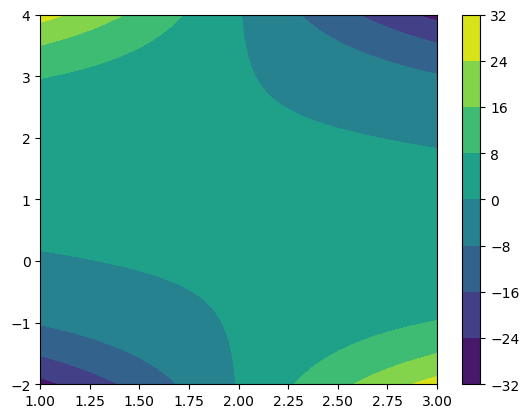

In [5]:
plt.contourf((X+2),(Y+1),Zf)
plt.colorbar()

In [6]:
max_order = 15
max_order = max_order+1
pairs, fhats, gamma1s, gamma2s = get_coefficents(max_order)

0  of  17  iterations
10  of  17  iterations
0  of  151  iterations
100  of  151  iterations


In [7]:
# max_order = 100
# pairs = get_pairs(max_order)
# fhats = np.load('fhats_100.npy')

In [8]:
# np.save('fhats_20',fhats)

Zp = proj_eval(X,Y,pairs,fhats)

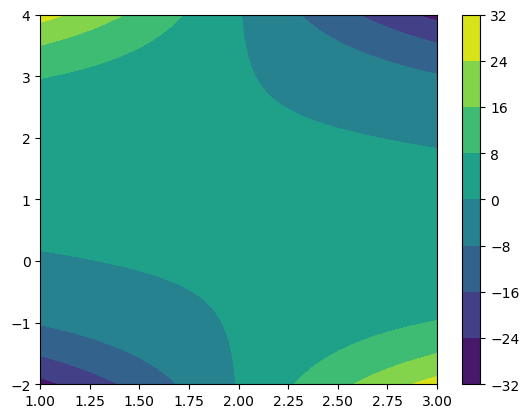

In [9]:
plt.contourf((X+2),(Y+1),Zp)
plt.colorbar()

In [35]:
# probability distribution
pZ = 1/2 * np.ones(Zf.shape)
pZ = np.multiply(normal_pdf(Y), pZ)

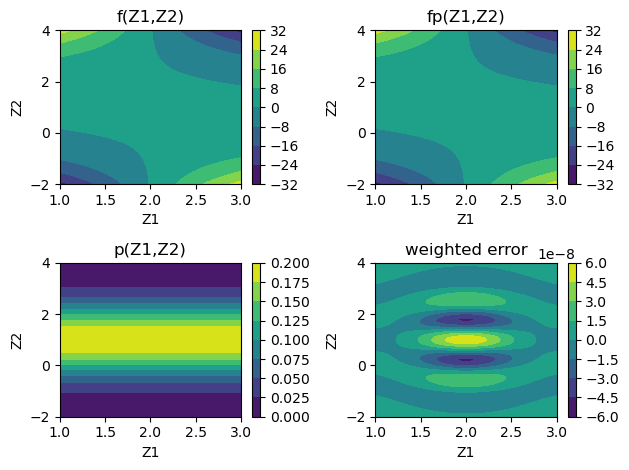

In [38]:
fig, axs = plt.subplots(2, 2)
c00 = axs[0,0].contourf((X+2),(Y+1),Zf)
axs[0,0].set_title('f(Z1,Z2)')
axs[0,0].set_xlabel('Z1')
axs[0,0].set_ylabel('Z2')
plt.colorbar(c00, ax=axs[0,0])

c01 = axs[0,1].contourf((X+2),(Y+1),Zp)
axs[0,1].set_title('fp(Z1,Z2)')
axs[0,1].set_xlabel('Z1')
axs[0,1].set_ylabel('Z2')
plt.colorbar(c01, ax=axs[0,1])

c10 = axs[1,0].contourf((X+2),(Y+1),pZ)
axs[1,0].set_title('p(Z1,Z2)')
axs[1,0].set_xlabel('Z1')
axs[1,0].set_ylabel('Z2')
plt.colorbar(c10, ax=axs[1,0])

c11 = axs[1,1].contourf((X+2),(Y+1),(Zf-Zp)*pZ)
axs[1,1].set_title('weighted error')
axs[1,1].set_xlabel('Z1')
axs[1,1].set_ylabel('Z2')
plt.colorbar(c11, ax=axs[1,1])
fig.tight_layout()

In [14]:
# use the calculated coesfficents to get the errors for lower orders
orders = np.arange(0,max_order)
terms = []
errors = []

for order in orders:
    ord_pairs = get_pairs(order)
    terms.append(len(ord_pairs))
    ord_fhats = []
    for i,pair in enumerate(pairs):
        if pair in ord_pairs:
            ord_fhats.append(fhats[i])
    
    Zp = proj_eval(X,Y,ord_pairs,ord_fhats)
    wE = np.linalg.norm((Zf-Zp)*pZ,2)/len(X) # np.sqrt(np.sum(((Zf-Zp)*pZ)**2))
    errors.append(np.sum(wE))

Text(0.5, 0, 'order')

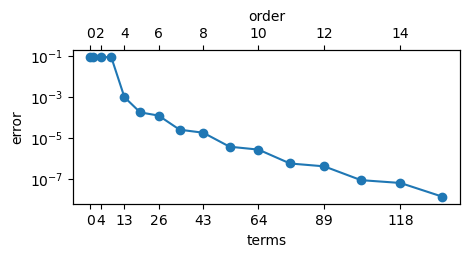

In [44]:
fig = plt.figure()
fig.set_size_inches(5,2)
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(terms, errors, marker = 'o')
ax1.set_xlabel(r"terms")
ax1.set_ylabel(r"error")
ax1.set_xticks(terms[0::2])
# ax1.set_xticklabels(terms)
ax1.set_yscale('log')

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(terms[0::2])
ax2.set_xticklabels(orders[0::2])
ax2.set_xlabel(r"order")

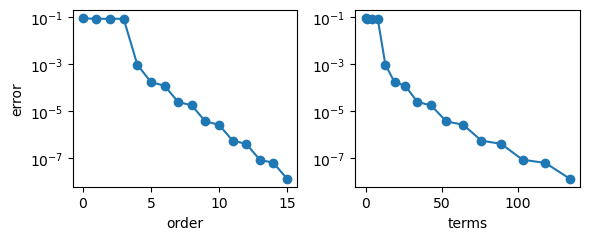

In [54]:
fig, [ax1, ax2] = plt.subplots(1,2)
fig.set_size_inches(6,2.5)

ax1.plot(orders, errors, marker = 'o')
ax1.set_xlabel(r"order")
ax1.set_ylabel(r"error")
ax1.set_yscale('log')

ax2.plot(terms, errors, marker = 'o')
ax2.set_yscale('log')
ax2.set_xlabel(r"terms")
fig.tight_layout()

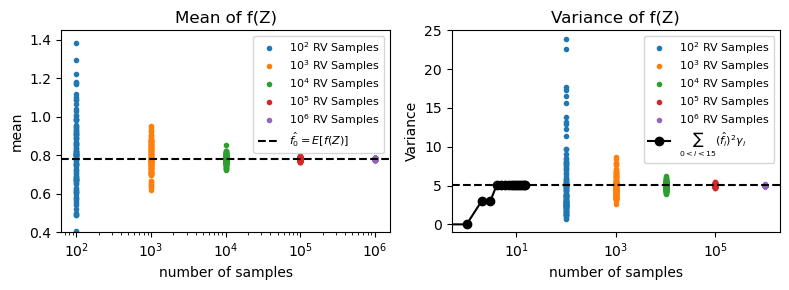

In [78]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(8,3)

samples = [100, 1000, 10000, 100000, 1000000]

sample_mean = {}
sample_var = {}
for num in samples:
    mean = []
    var = []
    for _ in range(120):
        Z1 = np.random.uniform(-1, 1,num)
        Z2 = np.random.normal(0,1,num)
        mean_MC = np.mean(function(Z1, Z2))
        var_MC = np.var(function(Z1, Z2))
        mean.append(mean_MC)
        var.append(var_MC)
    sample_mean[num] = mean
    sample_var[num] = var
    num_log10 = int(np.log10(num))
    axs[0].semilogx([num] * len(sample_mean[num]), sample_mean[num], '.', label=f"$10^{num_log10}$ RV Samples")

axs[0].axhline(fhats[0], color='black', linestyle='--', label=r'$\hat{f_0}=E[f(Z)]$')
axs[0].set_title("Mean of f(Z)")
axs[0].set_xlabel("number of samples")
axs[0].set_ylabel("mean")
axs[0].set_ylim(0.4, 1.45)
axs[0].legend(loc = 'upper right', prop = {"size" : 8}, labelspacing = 0.2 )

var_ord = []
for order in orders:
    ord_pairs = get_pairs(order)
    var = 0
    for i,pair in enumerate(pairs):
        if (pair in ord_pairs) and (pair != (0,0)):
            var += np.square(fhats[i]) * gamma1s[pair[0]] * gamma2s[pair[1]]
    var_ord.append(var)

for num in samples:
    num_log10 = int(np.log10(num))
    plt.semilogx([num] * len(sample_var[num]), sample_var[num], '.', label=f"$10^{num_log10}$ RV Samples")
axs[1].semilogx(var_ord, '-o', color='black', label=r"$\sum_{0< i <15} (\hat{f_i})^{2}\gamma_i$")
axs[1].axhline(var_ord[-1], color='black', linestyle='--')
axs[1].set_title("Variance of f(Z)")
axs[1].set_xlabel("number of samples")
axs[1].set_ylabel("Variance")
axs[1].legend(loc = 'upper right', prop = {"size" : 8}, labelspacing = 0.2 )
axs[1].set_ylim(-1,25)
fig.tight_layout()

6.0